In [1]:
from UTILITY_quickstart import *
from scipy.optimize import minimize

importedDefaultSettings = loadConfig("setLattice_configs/defaults.yml") | loadConfig("setLattice_configs/bounds.yml")

tao = initializeTao()

setLattice(tao, **importedDefaultSettings)

launchTwissCorrection(tao)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_configs/defaults.yml
WARNING! No beam file is specified!
Number of macro particles defined by input file
Beam created, written to /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/beams/activeBeamFile.h5, and reinit to tao
No evalElement provided. Assuming golden lattice PR10571
Optimization Results:
Optimal Parameters: [0.13755483 0.95354498 0.40561992 2.20428422]
Objective Function Value at Optimal Parameters: 1.5713418835634475e-09
Number of Iterations: 93
Converged: True


In [2]:
startElement = "HLAM" #This is upstream of the BC20 launch quads
endElement = "XTCAVF"
collElement = "CN2069"

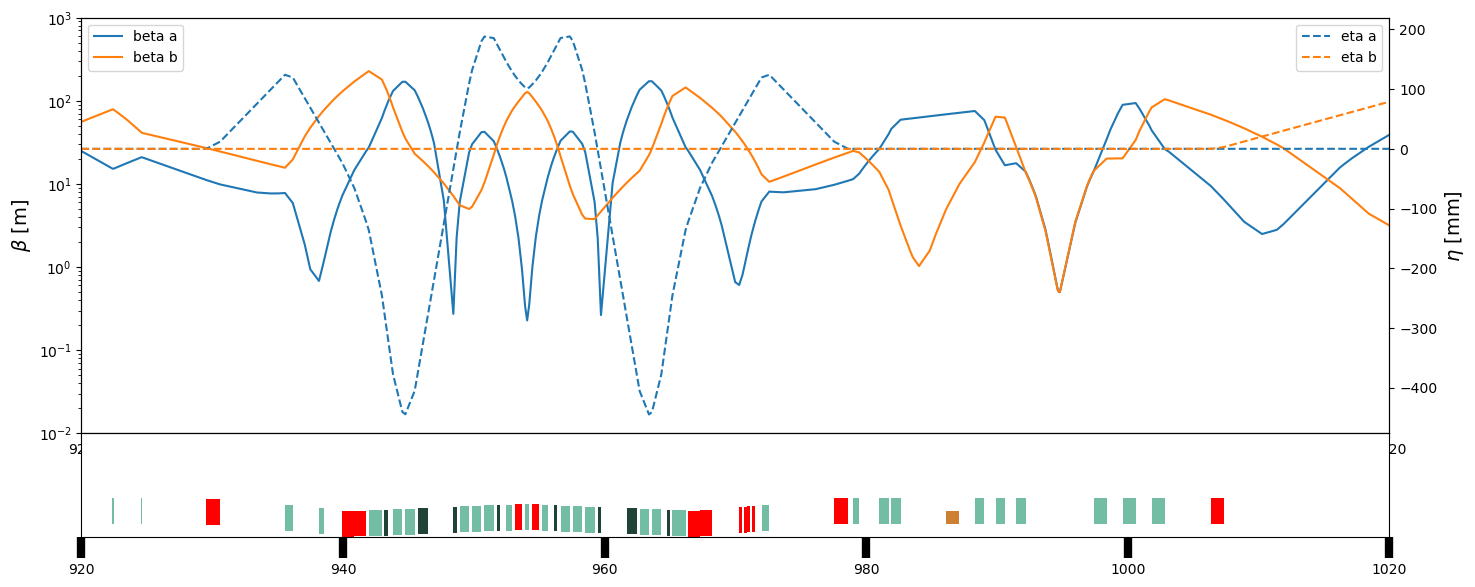

In [3]:
floorplanPlot(
    tao,
    zmin = 920,
    zmax = 1020,
    ymin = 0.01,
    ymax = 1000
)

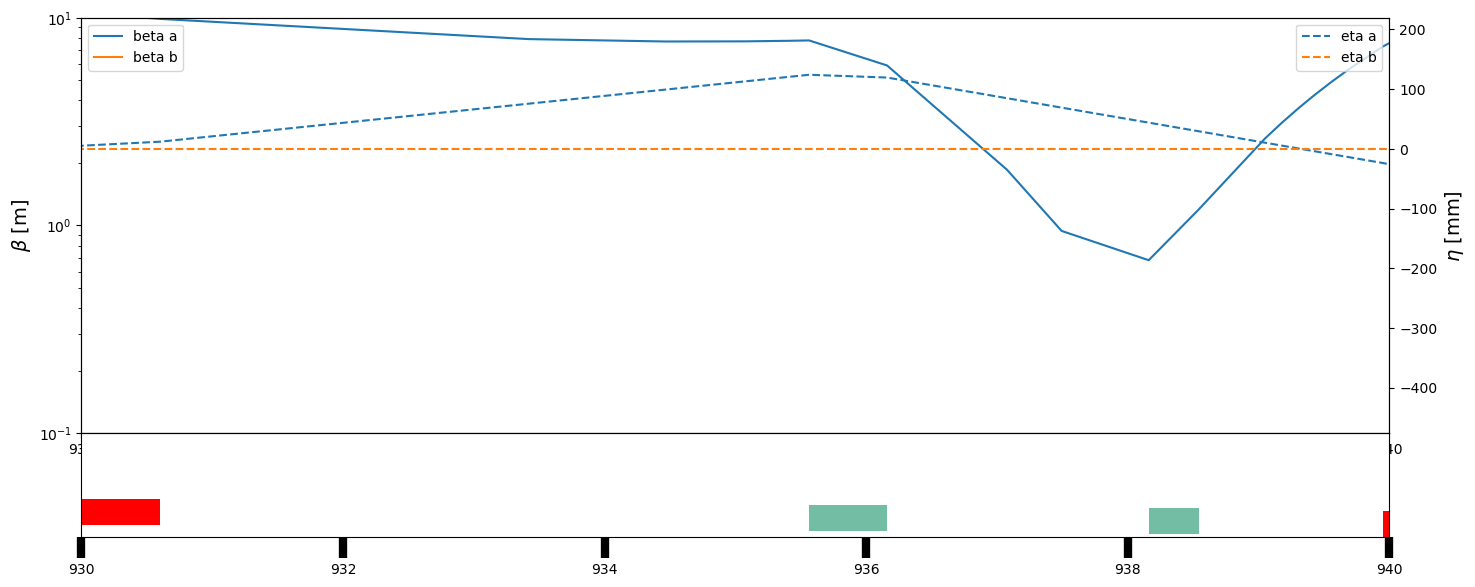

In [4]:
floorplanPlot(
    tao,
    zmin = 930,
    zmax = 940,
    ymin = 0.1,
    ymax = 10
)

In [5]:
baselineTransportMatrix = getMatrix( tao, startElement, endElement, print = True)
baselineTransportVector = getMatrix( tao, startElement, endElement, order = 0, print = True)

1.795365,-37.393114,0.000000,0.000000,0.000000,0.000017
0.059641,-0.687214,0.000000,0.000000,-0.000000,-0.000001
-0.000000,0.000000,0.498010,-2.454026,0.000000,0.000000
-0.000000,0.000000,0.181125,1.108177,0.000000,0.000000
0.000002,-0.000031,0.000000,0.000000,1.000000,-0.006975
-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.996370


0.000000
0.000000
0.000000
0.000000
-0.000000
0.000000


In [6]:
tao.ele_twiss(collElement)

{'mode_flip': False,
 'beta_a': 1.85212887377607,
 'alpha_a': 1.43690002508429,
 'gamma_a': 1.65468058161582,
 'phi_a': 56.240313533596,
 'eta_a': 0.0847957854882629,
 'etap_a': -0.0377727137590693,
 'beta_b': 37.3627955717428,
 'alpha_b': -11.1789009386438,
 'gamma_b': 3.37147754252306,
 'phi_b': 53.807997126887,
 'eta_b': 2.0089689243893e-18,
 'etap_b': 5.21447161281108e-19,
 'eta_x': 0.0847957854882629,
 'etap_x': -0.0377727137590693,
 'eta_y': 2.22932638117166e-18,
 'etap_y': 6.35716317773657e-19}

In [7]:
tao.cmd(f"show ele {collElement}")

['Element # 1308',
 'Element Name: CN2069',
 'Element Type:  "notch"',
 'Key: Rcollimator',
 'S_start, S:    937.077555,    937.077555',
 'Ref_time_start, Ref_time:  3.125771E-06,  3.125771E-06',
 '',
 'Attribute values [Only non-zero values shown]:',
 '    1  L                           =  0.0000000E+00 m',
 '   10  FRINGE_TYPE                 =  None (1)               11  FRINGE_AT                   =  Both_Ends (3)',
 '   13  SPIN_FRINGE_ON              =  T (1)',
 '   17  STATIC_LINEAR_MAP           =  F (0)',
 '   53  P0C                         =  9.9984356E+09 eV           BETA                        =  1.0000000E+00',
 '   54  E_TOT                       =  9.9984356E+09 eV           GAMMA                       =  1.9566450E+04',
 '   64  REF_TIME_START              =  3.1257713E-06 sec      50  DELTA_REF_TIME              =  0.0000000E+00 sec',
 '   65  INTEGRATOR_ORDER            = 0',
 '   67  DS_STEP                     =  2.0000000E-01 m        66  NUM_STEPS               

In [8]:
np.sum(( 0*baselineTransportMatrix - baselineTransportMatrix )**2)

1411.4680854377743

In [9]:
freeParameters = [
    "Q19851kG", "Q19871kG", 
    "Q1EkG", "Q2EkG", "Q3EkG", "Q4EkG", "Q5EkG", "Q6EkG", 
    #"B1EkG", "B2EkG", "B3EkG",
    "Q5FFkG", "Q4FFkG", "Q3FFkG", 
]
initialGuess = [ importedDefaultSettings[param] for param in freeParameters ]


initialGuess = [-86.58732023993655, 58.39160186910111, 217.5685784259581, -139.08072160709597, 102.86379565581485, 159.49610757555462, -109.02571310072378, -45.21629119302122, -76.9001927504818, -0.0014223726045127436, 46.760232611333585]



initialGuess

[-86.58732023993655,
 58.39160186910111,
 217.5685784259581,
 -139.08072160709597,
 102.86379565581485,
 159.49610757555462,
 -109.02571310072378,
 -45.21629119302122,
 -76.9001927504818,
 -0.0014223726045127436,
 46.760232611333585]

In [10]:
bounds = [ eval(importedDefaultSettings[ param + "Bounds"]) for param in freeParameters ]
bounds

[(-101, 0),
 (0, 101),
 (0, 388),
 (-364, 0),
 (0, 299),
 (0, 304),
 (-117, 0),
 (-301, 0),
 (-256, 0),
 (-446, 0),
 (0, 457)]

In [11]:
runningDataFilePath = "/tmp/runningData.csv"

try:
    os.remove(runningDataFilePath)
except OSError:
    pass

iter = 0
iterSinceLastUpdate = 0
bestError = 1e100

def objective(params, tao):
    global iter, iterSinceLastUpdate, bestError
    
    iter += 1
    iterSinceLastUpdate += 1
    overrides = { freeParameters[i] : params[i] for i in range(len(freeParameters)) }
    
    try:
        #Prevent recalculation until changes are made
        tao.cmd("set global lattice_calc_on = F")
        
        setLattice(tao, **( importedDefaultSettings | overrides ) )
        
        #Reenable lattice calculations
        tao.cmd("set global lattice_calc_on = T")
    
    except: #If Bmad doesn't like the proposed solution, don't crash, give a bad number
        return 1e20


    activeTransportMatrix = getMatrix( tao, startElement, endElement)
    activeTransportVector = getMatrix( tao, startElement, endElement, order = 0)

    dispersionErrorWeight = 1e3
    transportMatrixErrorWeights = np.array([
        [1,1,1,1,1,dispersionErrorWeight],
        [1,1,1,1,1,dispersionErrorWeight],
        [1,1,1,1,1,dispersionErrorWeight],
        [1,1,1,1,1,dispersionErrorWeight],
        [1,1,1,1,1,1],
        [1,1,1,1,1,1],
    ])
    
    transportMatrixError = np.sum( (transportMatrixErrorWeights * ( activeTransportMatrix - baselineTransportMatrix ) )**2 )
    transportVectorError = np.sum( ( activeTransportVector - baselineTransportVector )** 2 )
    
    collBeta = tao.ele_twiss(collElement)["beta_a"]

    minimizeMe = collBeta + transportMatrixError + transportVectorError

    if minimizeMe < bestError or (iterSinceLastUpdate > 100):
        bestError = min(bestError, minimizeMe)
        iterSinceLastUpdate = 0
        
        with open(runningDataFilePath, "a") as myfile:
            myfile.write(f"{iter}, {minimizeMe}\n")

    
    
    return minimizeMe

In [12]:
from scipy.optimize import minimize
result = minimize(
    objective, 
    initialGuess, #Starting point
    method='Nelder-Mead',
    #method = "COBYQA",
    #method = "L-BFGS-B",
    #method = "powell",
    bounds = bounds,
    args = (tao, ),
    options = {"adaptive" : True, "maxiter" : 100000}
)




# from scipy.optimize import differential_evolution

# totalPopSize = 50            # Total population size
# numDimensions = len(bounds)  # Number of parameters

# # populationDE = np.random.rand(totalPopSize, numDimensions)
# # for i in range(numDimensions):
# #     low, high = bounds[i]
# #     populationDE[:, i] = low + populationDE[:, i] * (high - low)  
    

# populationDE = np.zeros((totalPopSize, numDimensions))
# for i in range(numDimensions):
#     low, high = bounds[i]

#     mean = initialGuess[i]
    
#     std_dev = (high - low) / 10000
#     populationDE[:, i] = np.random.normal(mean, std_dev, totalPopSize)


# #Optional: Add specific points to initial evaluation list
# #populationDE = np.vstack([[ initialGuess ], populationDE])


# result = differential_evolution(
#     objective, 
#     bounds = bounds,
#     args = (tao, ),
#     init = populationDE
# )

                      
print("Optimization Results:")
print(f"Optimal Parameters: {list(result.x)}")
print(f"Objective Function Value at Optimal Parameters: {result.fun}")
print(f"Number of Iterations: {result.nit}")
print(f"Converged: {result.success}")



Optimization Results:
Optimal Parameters: [-35.91638288264363, 0.007543889123054931, 295.21833108812945, -98.78103504154808, 91.67194083485359, 194.53009729447885, -116.14338153207112, -47.64367116513345, -148.386024208063, -3.0102345130284593, 56.85572162720145]
Objective Function Value at Optimal Parameters: 0.11830608924193053
Number of Iterations: 100000
Converged: False


In [13]:
overrides = { freeParameters[i] : (result.x)[i] for i in range(len(freeParameters)) }

#Prevent recalculation until changes are made
tao.cmd("set global lattice_calc_on = F")

setLattice(tao, **( importedDefaultSettings | overrides ) )

#Reenable lattice calculations
tao.cmd("set global lattice_calc_on = T")

[]

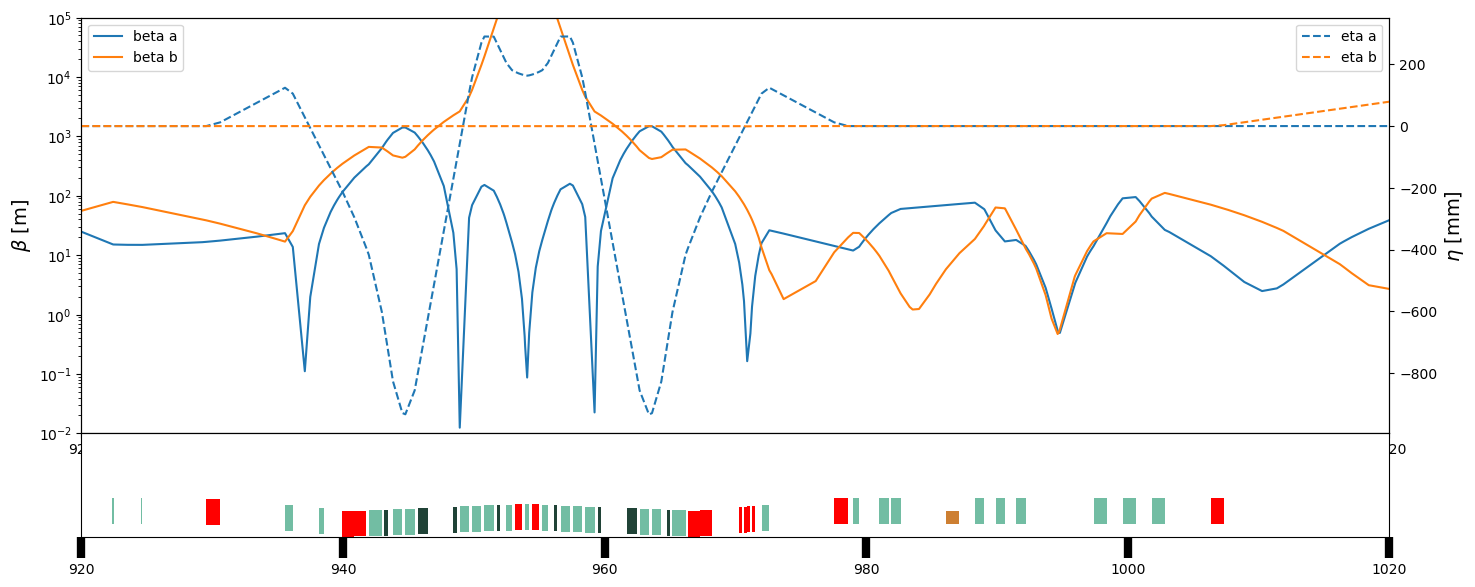

In [14]:
floorplanPlot(
    tao,
    zmin = 920,
    zmax = 1020,
    ymin = 0.01,
    ymax = 100000
)

In [15]:
tao.ele_twiss(collElement)

{'mode_flip': False,
 'beta_a': 0.111127720287332,
 'alpha_a': 0.780402221499418,
 'gamma_a': 14.4790842749309,
 'phi_a': 56.3577685335545,
 'eta_a': 0.0283933158000917,
 'etap_a': -0.0835491611126527,
 'beta_b': 69.1583009956086,
 'alpha_b': -29.7022010295236,
 'gamma_b': 12.7710012143635,
 'phi_b': 53.6748127940419,
 'eta_b': 3.36311115648609e-18,
 'etap_b': 1.38735721341425e-18,
 'eta_x': 0.0283933158000917,
 'etap_x': -0.0835491611126527,
 'eta_y': 3.3954335258684e-18,
 'etap_y': 1.44942571929801e-18}

In [16]:
overrides

{'Q19851kG': -35.91638288264363,
 'Q19871kG': 0.007543889123054931,
 'Q1EkG': 295.21833108812945,
 'Q2EkG': -98.78103504154808,
 'Q3EkG': 91.67194083485359,
 'Q4EkG': 194.53009729447885,
 'Q5EkG': -116.14338153207112,
 'Q6EkG': -47.64367116513345,
 'Q5FFkG': -148.386024208063,
 'Q4FFkG': -3.0102345130284593,
 'Q3FFkG': 56.85572162720145}

In [17]:
getMatrix( tao, startElement, endElement, print = True);

1.872587,-37.393706,0.000000,0.000000,0.000000,0.000015
0.060244,-0.670936,0.000000,0.000000,-0.000000,-0.000000
-0.000000,0.000000,0.520028,-2.455804,0.000000,0.000000
-0.000000,0.000000,0.169450,1.115772,0.000000,0.000000
0.000001,-0.000012,0.000000,0.000000,1.000000,-0.023143
0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.996370
